# CNN for 3D brain images
Dataset: OASIS-1
- Save the sata (disc1-12) in a folder under ./data/OASIS/ALL
- Run prepare/get_data_3d.py
- Split data into train and test by tunning prepare/oasis_make_train_test.py (requires meta data)

### Setup

In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import nibabel as nib
from keras import metrics
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from scipy import ndimage
import cv2



### Preprocessing
To process the data, we do the following:

- We rotate the volumes by 90 degrees, so the orientation is fixed
- We scale the greyscale values to be between 0 and 1.
- We resize width, height and depth to 128, 128, 64,


In [2]:

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min0 = min(np.unique(volume))
    max0 = max(np.unique(volume))
    #[volume < min0] = min0
    #volume[volume > max0] = max0
    volume = (volume - min0) / (max0 - min0)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[2]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor,1), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [3]:
# open meta sheet for train
#data_info = pd.read_csv('../data/OASIS/meta_train.csv')
data_info = pd.read_csv('F:\\MRI_class\\data\\OASIS\\meta_train.csv')
normal_scan_paths = data_info.loc[data_info.CDR == 0, 'file'].to_list()
abnormal_scan_paths = data_info.loc[data_info.CDR > 0, 'file'].to_list()
print("MRI scans with normal tissue: " + str(len(normal_scan_paths)))
print("MRI scans with abnormal tissue: " + str(len(abnormal_scan_paths)))

MRI scans with normal tissue: 185
MRI scans with abnormal tissue: 57


In [4]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

## Build train and validation datasets


In [5]:
# Split data in the ratio 70-30 for training and validation.
boundary_abnormal = int(np.ceil(len(abnormal_scans) * 0.7))
boundary_normal = int(np.ceil(len(normal_scans) * 0.7))
x_train = np.concatenate((abnormal_scans[:boundary_abnormal], normal_scans[:boundary_normal]), axis=0)
y_train = np.concatenate((abnormal_labels[:boundary_abnormal], normal_labels[:boundary_normal]), axis=0)
x_val = np.concatenate((abnormal_scans[boundary_abnormal:], normal_scans[boundary_normal:]), axis=0)
y_val = np.concatenate((abnormal_labels[boundary_abnormal:], normal_labels[boundary_normal:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 170 and 72.


## Data augmentation
The CT scans also augmented by rotating at random angles during training. Since the data is stored in rank-3 tensors of shape (samples, height, width, depth), we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on the data. The new shape is thus (samples, height, width, depth, 1). There are different kinds of preprocessing and augmentation techniques out there, this example shows a few simple ones to get started.

In [6]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    #volume = rotate(volume)
    #volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    #volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [14]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batch_size = 2

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    #.prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    #.prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)
Label: tf.Tensor([0 0], shape=(2,), dtype=int32)


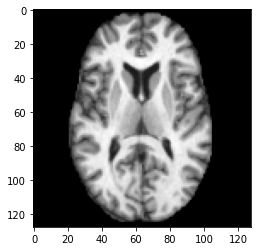

In [20]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]

images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
print("Label:", labels)

plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

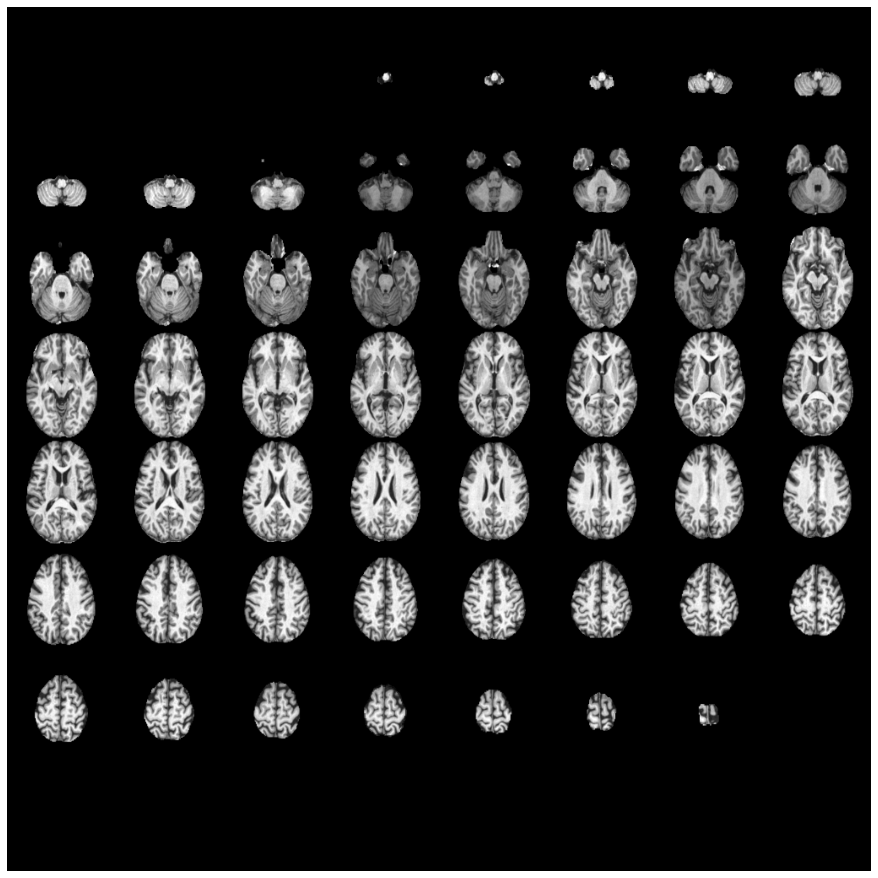

In [19]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
#plot_slices(4, 10, 128, 128, image[:, :, :40])
plot_slices(8, 8, 128, 128, image)


# CNN

In [15]:
from tensorflow.keras import layers, models
#iniziating model architecture
width=128
height=128
depth=64
model = models.Sequential()
model.add(layers.Conv3D(64, (9,9,9), activation='relu', input_shape=(width, height, depth, 1)))
model.add(layers.MaxPooling3D((2,2,2), strides=1))
model.add(layers.Conv3D(64, (7,7,7), activation='relu'))
model.add(layers.MaxPooling3D((2,2,2), strides=2))
model.add(layers.Conv3D(64, (5,5,5), activation='relu'))
model.add(layers.MaxPooling3D((2,2,2), strides=3))
model.add(layers.Conv3D(64, (3,3,3), activation='relu'))
model.add(layers.MaxPooling3D((2,2,2), strides=4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 120, 120, 56, 64)  46720     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 119, 119, 55, 64)  0        
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 113, 113, 49, 64)  1404992   
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 56, 56, 24, 64)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 52, 52, 20, 64)    512064    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 17, 17, 7, 64)    0

In [16]:
#add dense layes to conv layers
model.add(layers.Flatten())
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(1, activation="sigmoid"))

In [17]:
# # Compile model.
# initial_learning_rate = 0.0001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
# )
# model.compile(
#     loss="binary_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
#     metrics=[metrics.Precision(), metrics.Recall()],
# )
# # Define callbacks.
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "3d_image_classification.h5", save_best_only=True
# )
#early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
# Train the model, doing validation at the end of each epoch

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=10000,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=[metrics.Precision(), metrics.Recall()])




keras.backend.clear_session()
epochs = 10
with tf.device("/gpu:0"):
    history = model.fit(
                train_dataset,
                validation_data=validation_dataset,
                epochs=epochs,
                shuffle=True
                )

            

Epoch 1/10
85/85 [==============================] - 91s 794ms/step - loss: 0.0000e+00 - precision: 0.2500 - recall: 0.0750 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
85/85 [==============================] - 67s 790ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
85/85 [==============================] - 67s 787ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
85/85 [==============================] - 67s 790ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
85/85 [==============================] - 67s 790ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+0

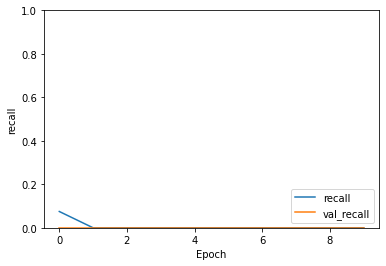

In [18]:

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# ConvNet

In [ ]:
stop
#3D convnet model
from keras.utils import to_categorical
from keras.layers import Input,Dense,Flatten,Dropout,Conv3D,MaxPooling3D,Activation, Conv3DTranspose
# merge
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model,Sequential,load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K

from keras import activations
batch_size = 20 #20
epochs = 60 #60
width=128
height=128
depth=64
input_img = Input(shape = (width, height, depth,1))

def model(input_img):
    conv1 = Conv3D(50, (3, 3, 3), padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1) #14 x 14 x 32
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(rate = 0.5)(conv1)
    
    conv2 = Conv3D(100, (3, 3, 3), padding='same',activation='relu')(conv1) #28 x 28 x 32
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2) #14 x 14 x 32
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(rate = 0.5)(conv2)
    
    conv3 = Conv3D(100, (3, 3, 3), padding='same',activation='relu')(conv2) #14 x 14 x 64
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3) #7 x 7 x 64
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(rate=0.5)(conv3)
    
    conv3 = Flatten()(conv3)
    #relu2 = Activation('relu')(flattened)
    
    #dense = Dense(100, activation='relu')(flattened) # 28 x 28 x 1
    dense = Dense(1, activation='sigmoid')(conv3) # 28 x 28 x 1
    return dense

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=10000,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

In [ ]:
model = Model(input_img, model(input_img))
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=[metrics.Precision(), metrics.Recall()])
#with adam optimiser lr = 0.001
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 128, 128, 64, 50)  1400      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64, 50)  200      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 64, 64, 32, 50)   0         
 )                                                               
                                                                 
 activation (Activation)     (None, 64, 64, 32, 50)    0         
                                                             

In [ ]:
keras.backend.clear_session()
epochs = 30
with tf.device("/gpu:0"):
    history = model.fit(
                train_dataset,
                validation_data=validation_dataset,
                epochs=epochs,
                shuffle=True
                )

Epoch 1/30
170/170 [==============================] - 9s 49ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
170/170 [==============================] - 8s 48ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
170/170 [==============================] - 8s 48ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
170/170 [==============================] - 8s 48ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
170/170 [==============================] - 8s 48ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_precision: 0

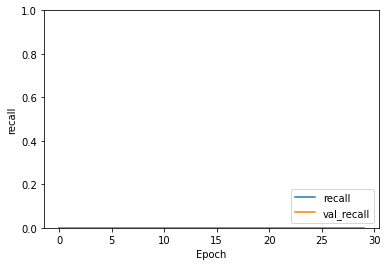

In [ ]:

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
from keras.layers import Input,Dense,Flatten,Dropout,Conv3D,MaxPooling3D,Activation, Conv3DTranspose, concatenate
from keras import layers, models

In [ ]:
keras.backend.clear_session()

width = 128
height = 128
depth = 64
channels = 1
img_size = (128, 128, 64, 1)
classes = 2
inputs = Input((height, width, depth, channels))

s = tf.keras.layers.Lambda(lambda x: x / 255) (inputs)

c1 = Conv3D(16, (3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv3D(16, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling3D((2)) (c1)

c2 = Conv3D(32, (3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv3D(32, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling3D((2)) (c2)

c3 = Conv3D(64, (3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv3D(64, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling3D((2)) (c3)

c4 = Conv3D(128, (3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv3D(128, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling3D(pool_size=(2)) (c4)

c5 = Conv3D(256, (3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv3D(256, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv3DTranspose(128, (2), strides=(2, 2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv3D(128, (3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv3D(128, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv3DTranspose(64, (2), strides=(2, 2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv3D(64, (3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv3D(64, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv3DTranspose(32, (2), strides=(2, 2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv3D(32, (3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv3D(32, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv3DTranspose(16, (2), strides=(2, 2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv3D(16, (3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv3D(16, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv3D(1, (1), activation='sigmoid') (c9)

model = models.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 64  0           ['input_1[0][0]']                
                                , 1)                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 64  448         ['lambda[0][0]']                 
                                , 16)                                                         

In [ ]:
#keras.backend.clear_session()
#Fit the model
with tf.device("/gpu:0"):
    history = model.fit(x=x_train,
                        y=y_train,
                         batch_size = 2,
                         epochs = 10,
                         validation_split = 0.2)

Epoch 1/10


ValueError: in user code:

    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((2, 128, 128, 128, 1) vs (2,)).


In [ ]:
keras.backend.clear_session()

width = 128
height = 128
depth = 64
channels = 1
img_size = (128, 128, 64, 1)
classes = 2
inputs = Input((height, width, depth, channels))

s = tf.keras.layers.Lambda(lambda x: x / 255) (inputs)

c1 = Conv3D(16, (3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv3D(16, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling3D((2)) (c1)

c2 = Conv3D(32, (3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv3D(32, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)


# u6 = Conv3DTranspose(16, (2), strides=(2, 2, 2), padding='same') (c2)
# u6 = concatenate([u6, c1])
# c6 = Conv3D(16, (3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c6 = Dropout(0.2) (c6)
# c6 = Conv3D(16, (3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

outputs = Conv3D(1, (1), activation='sigmoid') (c2)

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 64  0           ['input_1[0][0]']                
                                , 1)                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 64  448         ['lambda[0][0]']                 
                                , 16)                                                         

In [ ]:
with tf.device("/gpu:0"):
    history = model.fit(x=x_train,
                        y=y_train,
                         batch_size = 2,
                         epochs = 10,
                         validation_split = 0.2)

Epoch 1/10


ValueError: in user code:

    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "f:\alzheimer-classification\envwin\lib\site-packages\keras\backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((2, 128, 128, 128, 1) vs (2,)).
